<h1>Computer Vision and Image Processing</h1>
<h2>Fruit Inspection - Final Challenge</h2>
<h4>Gabriele Marconi<br/>Daniele Ceccarelli</h4>


In this document we will develop an <b>Image Processing routine</b> that solves the final challenge of
<a href="./fruit-inspection.pdf">this project</a> for every image given:
<ul>
    <li><a href="./asset/final_challenge/C1_000006.png">Image 06</a></li>
    <li><a href="./asset/final_challenge/C1_000007.png">Image 07</a></li>
    <li><a href="./asset/final_challenge/C1_000008.png">Image 08</a></li>
    <li><a href="./asset/final_challenge/C1_000009.png">Image 09</a></li>
    <li><a href="./asset/final_challenge/C1_0000010.png">Image 10</a></li>
</ul>

<b>NIR</b> versions of the same images are also provided:
<ul>
    <li><a href="./asset/final_challenge/C0_000006.png">NIR Image 06</a></li>
    <li><a href="./asset/final_challenge/C0_000007.png">NIR Image 07</a></li>
    <li><a href="./asset/final_challenge/C0_000008.png">NIR Image 08</a></li>
    <li><a href="./asset/final_challenge/C0_000009.png">NIR Image 09</a></li>
    <li><a href="./asset/final_challenge/C0_0000010.png">NIR Image 10</a></li>
</ul>

The objectives are:
<ol>
    <li><b>Segment</b> the fruits.</li>
    <li>Locate the <b>defect</b> in Image 07.</li>
    <li>Remove as background the <b>dirt</b> on the conveyor.</li>
    <li>Remove as background the <b>sticker</b> in Image 06</li>
</ol>
It is advised to <b><i>Run All</i></b> the scripts before reading the document, for a better understanding of the report.<br/><br/>
The code begins by importing all of the necessary packages.

In [11]:
import cv2
from cv2 import pointPolygonTest
import numpy as np
from matplotlib import pyplot as plt

<b><i>Choose the image.</i></b>

In [12]:
class Image_num():
    IMG6="06"
    IMG7="07"
    IMG8="08"
    IMG9="09"
    IMG10="10"

IMAGE = Image_num.IMG7

We also import both the colored image and the NIR image using <b>OpenCV</b>.<br/>
Then, we make a copy of the colored image that will be used to show the final results.

In [13]:
image=cv2.imread("./asset/final_challenge/C0_0000"+IMAGE+".png",cv2.IMREAD_GRAYSCALE)
img = cv2.imread("./asset/final_challenge/C1_0000"+IMAGE+".png")
final_img=img.copy()

<h4>Fruit Segmentation</h4>
<h5>Generating a binary mask</h5> 

As with the previous tasks, the first part of the script aims to <b>isolate the fruit</b> by generating a mask.<br/>
This section of the process uses the NIR grayscale image, as it has better contrast and is easier to work with.<br/>

In this particular case, we use a <b>standard thresholding function</b> instead of the <b>adaptive</b> version.<br/>
The reason for this is that an adaptive threshold would always include some parts of the <b>conveyor belt</b> because of the heterogeneous nature of the images, but a fine tuned standard threshold performed much better while also removing some parts of the unwanted <b>dirt</b>.<br/>
We were confortable in doing this as the lighting, contrast, camera placement and other parameters of all the images stayed consistent.<br/>

Next, all contours are found and sorted based on their area. We take the biggest one (removing the remaining <b>dirt</b> and <b>conveyor parts</b>) and draw it by filling its content onto a blank image.<br/>
We now have the outline of the fruit in the form of a <b>binary mask</b>.<br/>

Finally, we apply the mask to the colored image.

As always, <b>the function parameters were determined empirically</b>.

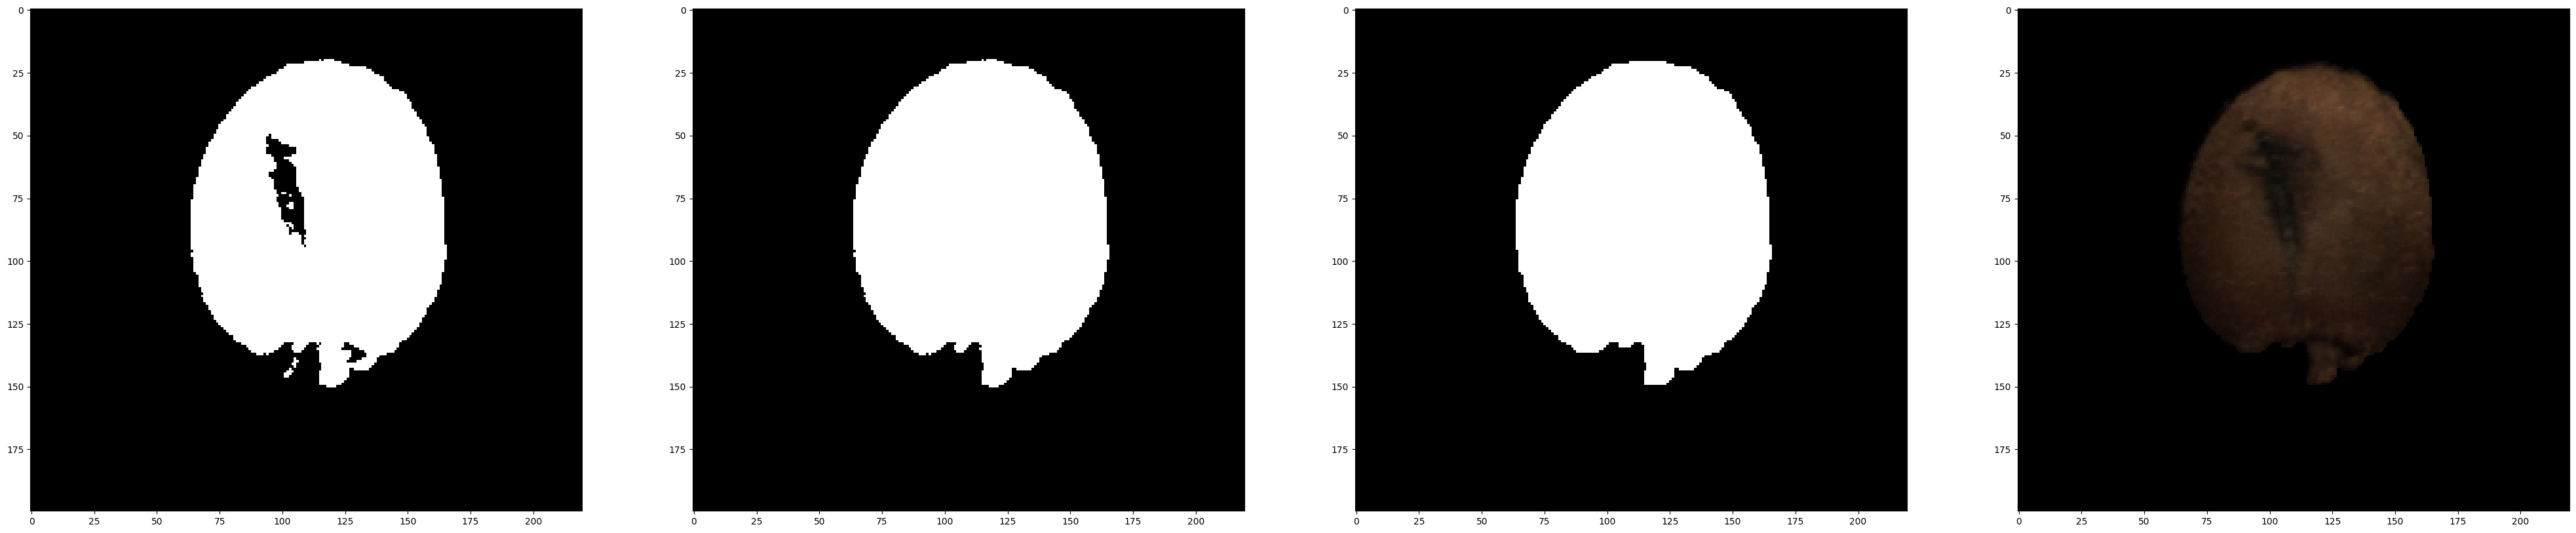

In [14]:
ret,t_image=cv2.threshold(image,40,255,cv2.THRESH_BINARY)

contours,hier=cv2.findContours(t_image,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
blank=np.zeros(image.shape,np.uint8)
contours=list(contours)
contours.sort(key=cv2.contourArea,reverse=True)
cv2.drawContours(blank,contours,0,(255,255,255),-1)

kernel_opcl=cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
mask=cv2.morphologyEx(blank,cv2.MORPH_OPEN,kernel_opcl)

masked=cv2.bitwise_and(img,img,mask=mask)

temp_show=cv2.cvtColor(masked, cv2.COLOR_BGR2RGB)

f, axarr = plt.subplots(1,4, figsize=(50,50))
axarr[0].imshow(t_image,cmap='gray',vmin=0, vmax=255)
axarr[1].imshow(blank,cmap='gray',vmin=0, vmax=255)
axarr[2].imshow(mask,cmap='gray',vmin=0, vmax=255)
axarr[3].imshow(temp_show,vmin=0, vmax=255)
plt.show()

<h5>Removing the sticker</h5> 

In the <b>6th image</b> the sticker is included in the mask, as it has high intensity pixels and is contained in the outline contour.<br/>
For this reason, greyscale thresholding cannot work; instead we aim to remove it by using color analysis.<br/>

To do this, we first convert the masked image to HSV and determine the range of <b>hue values</b> inside the kiwi.<br/>
Then, the <i>inRange</i> function uses those values to consider just the pixels that fall between the upper and lower bound, thus creating a new binary mask where the sticker is mostly removed.<br/>

<img src="./resources/colored_sticker.png" alt="Girl in a jacket" width="200" height="200">
<img src="./resources/sticker_removing.png" alt="Girl in a jacket" width="200" height="200"><br/>

We again find the biggest contour and use it as a mask for the <b>NIR grayscale image</b> that will be used in the following section of the script.<br/>
Finally, we have obtained the true outline of the fruit.<br/>

<img src="./resources/sticker_removal.png" alt="Girl in a jacket" width="200" height="200"><br/>

Obviously, <i>the other images are not affected by this process.</i>


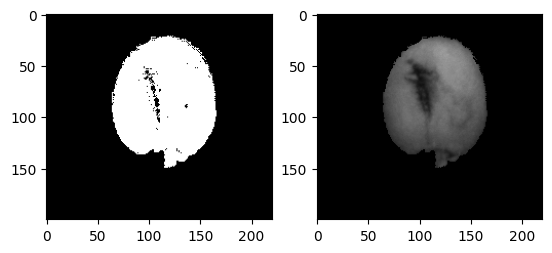

In [15]:
masked = cv2.cvtColor(masked, cv2.COLOR_BGR2HSV)

lower_kiwi = np.array([4,0,0])
upper_kiwi = np.array([15,255,150])
masked = cv2.inRange(masked, lower_kiwi, upper_kiwi)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(masked, cmap='gray',vmin=0, vmax=255)

contours,hier=cv2.findContours(masked,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
blank=np.zeros(image.shape,np.uint8)
contours=list(contours)
contours.sort(key=cv2.contourArea,reverse=True)
cv2.drawContours(blank,contours,0,(255,255,255),-1)

masked=cv2.bitwise_and(image,image,mask=blank)

axarr[1].imshow(masked, cmap='gray',vmin=0, vmax=255)

plt.show()

<h4>Defect Detection</h4>
In the 7th image the fruit presents a <b>defect</b> that needs to be detected. <br/>
First, we apply a <b>bilateral filter</b> to smooth the surface of the fruit while maintaining the edges, obtaining the following image:<br/><br/>
<img src="./resources/defect_before_AHE.png" alt="Girl in a jacket"><br/><br/>
Then, to better distinguish the defect from the fruit, we apply a <b>contrast enhancing algorithm</b>; in particular, we apply the <b>CLAHE</b> algorithm that operates locally instead of the standard histogram equalization, which would be negatively influenced by the large black background.<br/>
By enhancing the contrast, we obtain:<br/><br/>
<img src="./resources/defect_after_AHE.png" alt="Girl in a jacket"><br/>

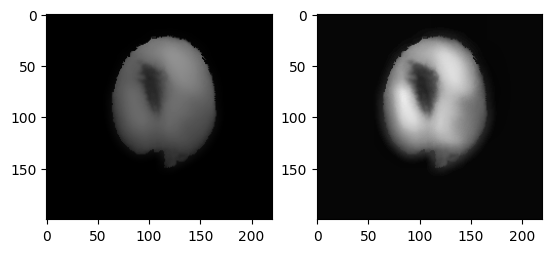

In [16]:
img_blur = cv2.bilateralFilter(masked, 20, 40, 40)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(img_blur, cmap='gray',vmin=0, vmax=255)
# Applying CLAHE to L-channel
clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(4,4))
cl = clahe.apply(img_blur)
# Stacking the original image with the enhanced image
result = np.hstack((img_blur, cl))
img_blur=cl

axarr[1].imshow(img_blur, cmap='gray',vmin=0, vmax=255)
plt.show()

After increasing the constrast, we want to <b>outline the defect</b> by finding its contour. <br/>
To do this we first use the <i>inRange</i> function to obtain a binary image in which the <b>defect is completely black</b> by setting as the lower bound of the range a value higher than the intensities inside the defect.<br/>
Then, we apply a <b>dilation</b> to diminish the possible granularity of the image and avoid unwanted contours.<br/>
As always, <b>the function parameters were determined empirically</b>.

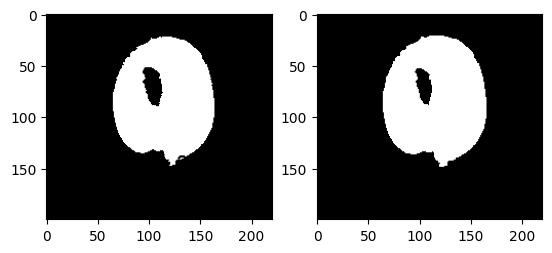

In [17]:
lower_kiwi = 70
upper_kiwi = 255
masked = cv2.inRange(img_blur, lower_kiwi, upper_kiwi)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(masked, cmap='gray',vmin=0, vmax=255)

kernel_dil=cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
dilated=cv2.dilate(masked,kernel_dil,iterations=1)
axarr[1].imshow(dilated, cmap='gray',vmin=0, vmax=255)
plt.show()

Now we find the contours of the image by using the function <i>findContours</i>, obtaining the outline of the fruit and, if present, the <b>outline of the defect</b>.

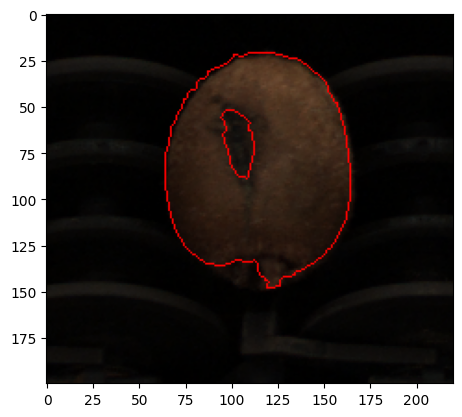

In [18]:
contours,hier=cv2.findContours(dilated,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img,contours,-1,(0,0,255),1)

temp_show=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(temp_show,vmin=0, vmax=255)
plt.show()

Since in the binary image we're considering the defect has a <b>black color</b>, we select only contours with a low mean intensity; by doing so, we filter out the contour that outlines the fruit.

In [19]:
filtered_contours = []
for idx, contour in enumerate(contours):
    blank = np.zeros(image.shape, dtype='uint8')
    cv2.drawContours(blank,contours,idx,(255,255,255),-1)

    locs = np.where(blank == 255)
    pixels = dilated[locs]

    if (np.mean(pixels) < 240):
        filtered_contours.append(contour)

If the fruit considered presents a defect, it is finally shown.

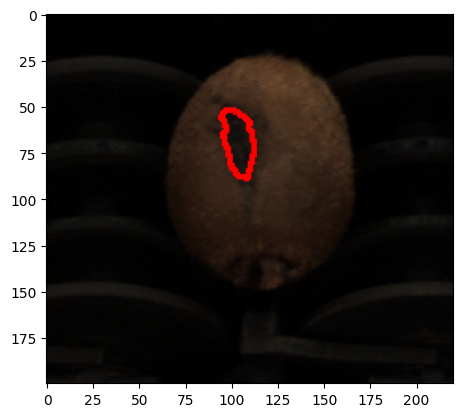

In [20]:
if filtered_contours:
    cv2.drawContours(final_img,filtered_contours,-1,(0,0,255),2)

    final_img=cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
    plt.imshow(final_img,vmin=0, vmax=255)
    plt.show()